In [1]:
import plaidml.keras
import os
plaidml.keras.install_backend()

In [2]:
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [3]:
import keras
import keras.backend as K

K

<module 'plaidml.keras.backend' from 'C:\\Users\\Bamouh Mohamed\\AppData\\Local\\conda\\conda\\envs\\Projectenv\\lib\\site-packages\\plaidml\\keras\\backend.py'>

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical
import cv2
from pynput.keyboard import Key, Controller
from keras.models import model_from_json
import glob

In [5]:
kernel = np.ones((3,3),np.uint8)

In [6]:
def process_image_from_video(img):
    img = cv2.resize(img, (128, 128))
    img = cv2.GaussianBlur(img,(5,5),0)
    _,img = cv2.threshold(img,20,255,cv2.THRESH_BINARY)
    
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv
    
    img = img/255
    return img

def process_image_for_training(img):
    img = cv2.resize(img, (128, 128))
    img = cv2.GaussianBlur(img,(5,5),0)
    _,img = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
    
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv
    
    img = img/255
    return img

def img_to_sample(img):
    img = img.astype(np.uint8)
    img = np.reshape(img, (128, 128))
    
    img = process_image_for_training(img)
    
    img = np.reshape(img, (128, 128, 1))
    return img

def loadModel(architecturePath="handmodel_fingers_architecture.json", weightsPath="handmodel_fingers_weights.hdf5"):
    # Model reconstruction from JSON file
    with open(architecturePath, 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(weightsPath)

    return model

In [7]:
pathTest = "fingers/test_sample/*"
NUMBER_OF_CLASSES = 6
#indice_to_label = {0:"0L", 1:"1L", 2:"2L", 3:"3L", 4:"4L", 5:"5L", 6:"0R", 7:"1R", 8:"2R", 9:"3R", 10:"4R", 11:"5R"}
indice_to_label = {6:"None", 0:"0", 1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}
label_to_indice = {v:k for k,v in indice_to_label.items()}

In [8]:
test_set = [(file[-6] ,img_to_sample(cv2.imread(file, 0))) for file in glob.glob(pathTest)]

In [9]:
X_Test = [t[1] for t in test_set]
X_Test = X_Test
Y_Test = [label_to_indice[t[0]] for t in test_set]
Y_Test = Y_Test

In [10]:
X_Test = np.array(X_Test)
Y_Test = to_categorical(Y_Test, num_classes = NUMBER_OF_CLASSES)

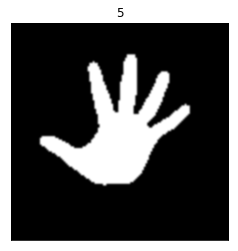

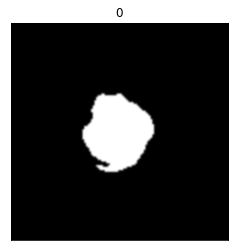

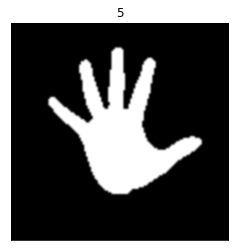

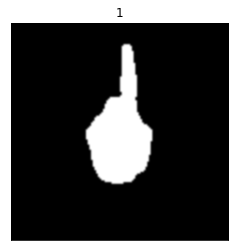

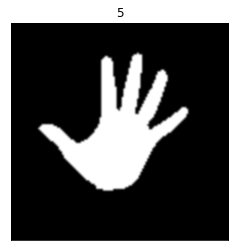

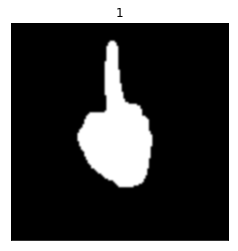

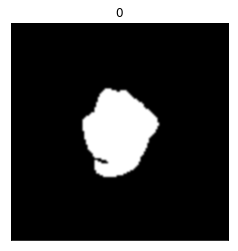

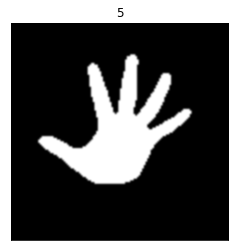

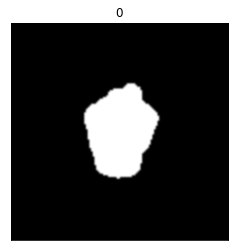

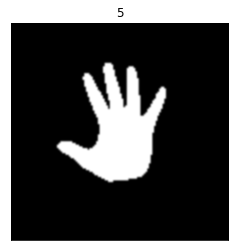

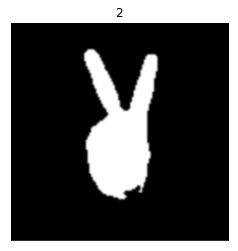

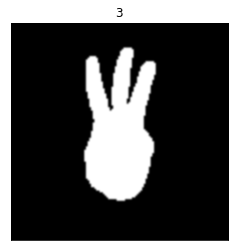

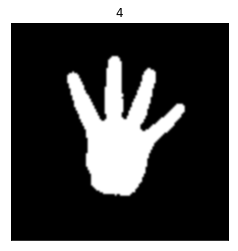

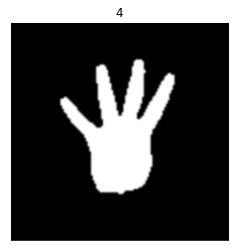

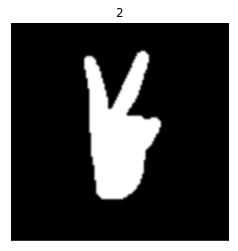

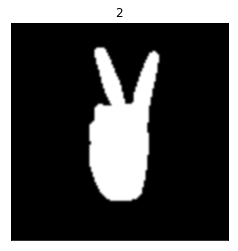

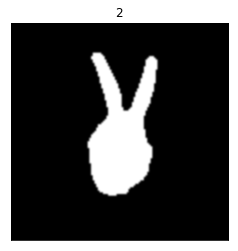

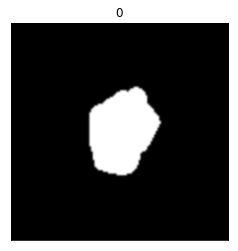

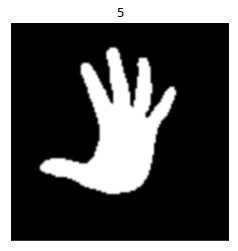

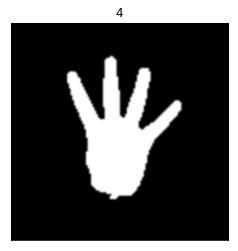

In [11]:
for i in range(20):
    plt.imshow(X_Test[i,:].reshape((128, 128)), cmap='gray', interpolation='bicubic')
    plt.title(indice_to_label[np.argmax(Y_Test[i])])
    plt.xticks([]), plt.yticks([])
    plt.show()

In [26]:
model = loadModel(architecturePath="models/handmodel_fingers_architecture_4(new architecture, overall good)/handmodel_fingers_architecture.json", weightsPath="models/handmodel_fingers_architecture_4(new architecture, overall good)/handmodel_fingers_weights.hdf5")

In [27]:
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
keyboard = Controller()

def get_zone_from_frame(frame, x1, y1, x2, y2):
    return frame[y1:y2, x1:x2, :]

def get_contours_hand(zone, name):
    zone = cv2.cvtColor(zone, cv2.COLOR_BGR2HSV)
    cv2.imshow('HSV zone {}'.format(name),zone)
    
    skinMask = cv2.inRange(zone, lower, upper)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
    
    zone = cv2.bitwise_and(zone, zone, mask = skinMask)
    zone = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    
    contours,_ = cv2.findContours(zone, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    hand_cnt = []
    try:
        hand_cnt = max(contours, key = cv2.contourArea)
    except:
        None
    
    return zone, hand_cnt

def get_hand_from_contours(zone, hand_cnt):
    
    (x,y,w,h) = cv2.boundingRect(hand_cnt)
    y1 = y - round(y/2) if y > 50 else y
    y2 = y+2*w
    x1 = x - round(x/2) if x > 50 else x
    x2 = x+w + round(x/2)
    hand = zone[y1:y2, x1:x2]
    hand = cv2.copyMakeBorder(hand,10,10,10,10, cv2.BORDER_CONSTANT, value = [0])
    #center = (round(y + (h/2)+10), round(x + w/2)+10)
    center = (round(y+10), round(x+10))
        
    return hand, center

def zone_to_hand_pose(zone, name, predict_pose = True):
    zone, hand_cnt = get_contours_hand(zone, name)
    
    predicted_class = 6
    labels = ""
    center = (0, 0)
        
    if len(hand_cnt) > 0:
        
        hand, center = get_hand_from_contours(zone, hand_cnt)
        
        cv2.imshow('hand {}'.format(name), zone)
            
        if predict_pose :
            hand = process_image_from_video(hand)

            for_prediction = hand.reshape((1, 128, 128, 1))

            preds = model.predict(for_prediction)
            predicted_class = np.argmax(preds)
            #labels = ["{} : {}%".format(k, format(preds[0][v]*100, '.2f')) for k,v in label_to_indice.items()]

            cv2.imshow('What the Network Sees {}'.format(name), hand)

    return predicted_class, labels, center

In [30]:
#Pong
cap = cv2.VideoCapture(0)

x11, y11, x21, y21 = (1, 50, 250, 350)
x12, y12, x22, y22 = (400, 50, 640, 350)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    frame = cv2.flip(frame,1)
    
    zone_left = get_zone_from_frame(frame, x11, y11, x21, y21)
    cv2.rectangle(frame,(x11,y11),(x21,y21),(0,255,0),3)
    
    zone_right = get_zone_from_frame(frame, x12, y12, x22, y22)
    cv2.rectangle(frame,(x12,y12),(x22,y22),(0,255,0),3)
    
    _,_, center_left = zone_to_hand_pose(zone_left, "left", predict_pose = False)
    XC1, YC1 = (center_left[1] + x11, center_left[0] + y11)
    cv2.circle(frame, (XC1, YC1), 5, (255,0,0), -1)
    
    _,_, center_right = zone_to_hand_pose(zone_right, "right", predict_pose = False)
    XC2, YC2 = (center_right[1] + x12, center_right[0] + y12)
    cv2.circle(frame, (XC2, YC2), 5, (255,0,0), -1)
        
    if YC1 > (y11 + y21)/2 and YC1 < y21:
        #keyboard.release('w')
        #keyboard.press('s')
        None
    else:
        #keyboard.release('s')
        #keyboard.press('w')
        None
        
    if YC2 > (y12 + y22)/2 and YC2 < y22:
        #keyboard.release(Key.up)
        #keyboard.press(Key.down)
        None
    else:
        #keyboard.release(Key.down)
        #keyboard.press(Key.up)
        None
        
    #if center_right[0] > :
    #    keyboard.press(Key.left)
    #else:
    #    keyboard.press(Key.left)

    # Display the resulting frame      
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break                                                                                                                     
                                                                   
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [34]:
#Super Mario
cap = cv2.VideoCapture(0)

x11, y11, x21, y21 = (1, 50, 250, 350)
x12, y12, x22, y22 = (400, 50, 640, 350)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    frame = cv2.flip(frame,1)
    
    zone_left = get_zone_from_frame(frame, x11, y11, x21, y21)
    cv2.rectangle(frame,(x11,y11),(x21,y21),(0,255,0),3)
    
    zone_right = get_zone_from_frame(frame, x12, y12, x22, y22)
    cv2.rectangle(frame,(x12,y12),(x22,y22),(0,255,0),3)
    
    predicted_class_left, labels_left, center_left = zone_to_hand_pose(zone_left, "left")
    predicted_class_right, labels_right, center_right = zone_to_hand_pose(zone_right, "right")
    
    if center_left[0] in [i for i in range(0,60)]:
        keyboard.press(Key.left)
        None
    elif center_right[0] in [i for i in range(0,60)]:
        keyboard.press(Key.right)
        None
    else:
        keyboard.release(Key.right)
        keyboard.release(Key.left)
        None
        
    if predicted_class_left == 5 or predicted_class_left == 4 or predicted_class_right == 5 or predicted_class_right == 4:
        keyboard.press(Key.space)
        None
    else:
        keyboard.release(Key.space)
        None
    
    y = 100
    cv2.putText(frame, indice_to_label[int(predicted_class_left)],(270,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0),2,cv2.LINE_AA)
    if labels_left != "":
        for label in labels_left:
            y = y + 20
            cv2.putText(frame, label,(270, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0),2,cv2.LINE_AA)
        
    yy = 250
    cv2.putText(frame, indice_to_label[int(predicted_class_right)],(270,yy), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0),2,cv2.LINE_AA)
    if labels_right != "":
        for label in labels_right:
            yy = yy + 20
            cv2.putText(frame, label,(270, yy), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0),2,cv2.LINE_AA)

    # Display the resulting frame      
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break                                                                                                                     
                                                                   
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [28]:
#Flappy bird
cap = cv2.VideoCapture(0)

x11, y11, x21, y21 = (1, 50, 250, 350)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    frame = cv2.flip(frame,1)
    
    zone = get_zone_from_frame(frame, x11, y11, x21, y21)
    cv2.rectangle(frame,(x11,y11),(x21,y21),(0,255,0),3)
    
    predicted_class, labels, _ = zone_to_hand_pose(zone, "zone")
    
    #if center_left == 1.0:
        #keyboard.press(Key.left)
    #    None
    #elif center_right == 1.0:
        #keyboard.press(Key.right)
    #    None
    #else:
        #keyboard.release(Key.right)
        #keyboard.release(Key.left)
    #    None
        
    if predicted_class == 5 or predicted_class == 4:
        #keyboard.press(Key.space)
        None
    else:
        #keyboard.release(Key.space)
        None
    
    y = 100
    cv2.putText(frame, indice_to_label[int(predicted_class)],(270,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0),2,cv2.LINE_AA)
    if labels != "":
        for label in labels:
            y = y + 20
            cv2.putText(frame, label,(270, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0),2,cv2.LINE_AA)

    # Display the resulting frame      
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break                                                                                                                     
                                                                   
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()